# Hands-On Assignment 3

2-1. Decision trees with Breast cancer dataset

2-2. Random Forest with Titanic dataset

## After finishing writing the code for each problem, submit your ipynb file (i.e., this file) to Cybercampus by **11/18 Monday 23:59**

### Submitters are as follows.
 *Note that hands-on assignments can be done collaboratively (**up to 2 students**)*

    Name:Eunwoo Choi
    Student ID: 2317035

    Name:
    Student ID:



---


## 2-1. Decision trees with Breast cancer dataset


---



Data importing

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

We learn the following Node and DecisionTree classes during the lab

In [2]:

class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label

    def is_leaf(self):
        return self.label is not None


class DecisionTree:

    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _stop(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False

    def _entropy(self, y):
        # np.bincount: Count number of occurrences of each value in array
        weights = np.bincount(y) / len(y)
        entropy = -np.sum([w * np.log2(w) for w in weights if w > 0])
        return entropy

    def _expand_tree(self, X, value):

        # np.argwhere: return indices of X which are less than and equal to value
        # np.flatten: turn multi-dimensional data into vectors
        left_idx = np.argwhere(X <= value).flatten()

        # return indices of X which are greater than
        right_idx = np.argwhere(X > value).flatten()
        return left_idx, right_idx

    # information_gain = parent_entropy - children_entropy
    def _information_gain(self, X, y, value):
            parent_entropy = self._entropy(y)

            # expand the tree with X
            left_idx, right_idx = self._expand_tree(X, value)

            n, n_left, n_right = len(y), len(left_idx), len(right_idx)

            if n_left == 0 or n_right == 0:
                return 0

            # each node has two children (right child and left child)
            children_entropy = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
            return parent_entropy - children_entropy

    def _best_split(self, X, y, features):
        # create split dict in which we record score, feature, and value to keep the split yielding the maximum score
        split = {'score':- 1, 'feat': None, 'value': None}

        # for each column in 30 columns
        for feat in features:
            # select one feature column
            # example: values in outlook column
            X_feat = X[:, feat]

            # np.unique: remove duplicates
            # create values
            values = np.unique(X_feat)

            # for each value in the column
            for value in values:

                # compute the information gain
                score = self._information_gain(X_feat, y, value)

                # Update the split with the maximum score
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['value'] = value

        # return the best split with the maximum score (i.e., information gain)
        return split['feat'], split['value']

    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # 1. Check whether go or stop: use stopping criteria using _stop function
        if self._stop(depth):
            most_common_Label = np.argmax(np.bincount(y))
            return Node(label=most_common_Label)

        # 2. find the best split: get the best feature for the current node among 30 features
        # random_f carries shuffled feature indices
        random_f = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_value = self._best_split(X, y, random_f)

        # 3. expand the tree: create the subtrees using the best split
        left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

        # 4. grow the left subtree and right subtree recursively
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_value, left_child, right_child)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)


    # For the evaluation using the testing set, we need a traverse function
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.label

        # recursively traverse the tree (left subtree)
        # node.feature = feature index, so compare X to current node's value
        if x[node.feature] <= node.value:
            return self._traverse_tree(x, node.left)

        # recursively traverse the tree (right subtree)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

## Goal: Change the "DecisionTree" class to use the gini importance (aka impurity) in the quality test for the node decision.
❗❗READ CAREFULLY ⬇

*   Use the classes provided in the lab
*   Use the breast cancer dataset
*   TO-DO:
  1. Update the `DecisionTree` class to use `_gini_importance` and `impurity_decrease` rather than `_entropy` and `_information_gain`.
  2. Train the Decision tree model using your updated `DecisionTree` class using `X_train`
  3. Test the trained model using `X_test` and report the accuracy.

- New DecisionTree Class

In [20]:
class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _stop(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False

    def _gini_importance(self, y):
        weights = np.bincount(y) / len(y)
        gini = 1 - np.sum([w ** 2 for w in weights if w > 0])
        return gini

    def _expand_tree(self, X, value):
        left_idx = np.argwhere(X <= value).flatten()
        right_idx = np.argwhere(X > value).flatten()
        return left_idx, right_idx

    def _impurity_decrease(self, X, y, value):
        parent_impurity = self._gini_importance(y)
        left_idx, right_idx = self._expand_tree(X, value)

        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0:
            return 0

        children_impurity = (n_left / n) * self._gini_importance(y[left_idx]) + \
                            (n_right / n) * self._gini_importance(y[right_idx])

        return parent_impurity - children_impurity

    def _best_split(self, X, y, features):
        split = {'score': -1, 'feat': None, 'value': None}

        for feat in features:
            X_feat = X[:, feat]
            values = np.unique(X_feat)

            for value in values:
                score = self._impurity_decrease(X_feat, y, value)

                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['value'] = value

        return split['feat'], split['value']

    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        if self._stop(depth):
            most_common_label = np.argmax(np.bincount(y))
            return Node(label=most_common_label)

        random_f = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_value = self._best_split(X, y, random_f)

        left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)

        return Node(best_feat, best_value, left_child, right_child)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.label

        if x[node.feature] <= node.value:
            return self._traverse_tree(x, node.left)

        return self._traverse_tree(x, node.right)

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)


- Using Breast Cancer

In [22]:
from sklearn.metrics import accuracy_score

tree_new = DecisionTree(max_depth=10, min_samples_split=2)
tree_new.fit(X_train, y_train)

y_pred = tree_new.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of new Decision Tree: {accuracy:.2f}")

Accuracy of new Decision Tree: 0.93




---


## 2-2. RandomForest with Titanic dataset


---



load dataset

In [23]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm' -O titanic.csv

--2024-11-18 06:06:43--  https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm
Resolving docs.google.com (docs.google.com)... 173.194.203.113, 173.194.203.139, 173.194.203.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.203.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm&export=download [following]
--2024-11-18 06:06:43--  https://drive.usercontent.google.com/download?id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [application/octet-stream]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.

Overview the dataset

*   data source: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv
*   'Survived' indicates whether or not the passenger survived

In [24]:
import pandas as pd
df2 = pd.read_csv('titanic.csv')
df2.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
print(df2.shape)

(891, 12)


Data preprocessing

In [26]:
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))

print('\nDuplicated values in data {}'.format(df2.duplicated().sum()))


Null Values in data 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Duplicated values in data 0


Preprocess Embarked column

In [27]:
print('Embarkation per ports \n{}'.format(df2['Embarked'].value_counts()))

# since the most common port is Southampton the chances are that the missing one is from there
df2['Embarked'].fillna(value='S', inplace=True)

print('Embarkation per ports after filling \n{}'.format(df2['Embarked'].value_counts()))


Embarkation per ports 
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarkation per ports after filling 
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


<ipython-input-27-0b9c56a009bb>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Embarked'].fillna(value='S', inplace=True)


Preprocess Age column

In [28]:
mean_age_miss = df2[df2["Name"].str.contains('Miss.', na=False)]['Age'].mean().round()
mean_age_mrs = df2[df2["Name"].str.contains('Mrs.', na=False)]['Age'].mean().round()
mean_age_mr = df2[df2["Name"].str.contains('Mr.', na=False)]['Age'].mean().round()
mean_age_master = df2[df2["Name"].str.contains('Master.', na=False)]['Age'].mean().round()

print('Mean age of Miss. title {}'.format(mean_age_miss))
print('Mean age of Mrs. title {}'.format(mean_age_mrs))
print('Mean age of Mr. title {}'.format(mean_age_mr))
print('Mean age of Master. title {}'.format(mean_age_master))

def fill_age(name_age):

    name = name_age[0]
    age = name_age[1]

    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

df2['Age'] = df2[['Name', 'Age']].apply(fill_age,axis=1)

Mean age of Miss. title 22.0
Mean age of Mrs. title 36.0
Mean age of Mr. title 33.0
Mean age of Master. title 5.0


<ipython-input-28-c356a6b16a6b>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name = name_age[0]
<ipython-input-28-c356a6b16a6b>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age = name_age[1]


Preprocess Cabin column

In [29]:
df2['Cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in df2['Cabin']])

In [30]:
print('Mean Fare of Cabin B {}'.format(df2[df2['Cabin']=='B']['Fare'].mean()))
print('Mean Fare of Cabin C {}'.format(df2[df2['Cabin']=='C']['Fare'].mean()))
print('Mean Fare of Cabin D {}'.format(df2[df2['Cabin']=='D']['Fare'].mean()))
print('Mean Fare of Cabin E {}'.format(df2[df2['Cabin']=='E']['Fare'].mean()))

def reasign_cabin(cabin_fare):

    cabin = cabin_fare[0]
    fare = cabin_fare[1]

    if cabin=='X':
        if (fare >= 113.5):
            return 'B'
        if ((fare < 113.5) and (fare > 100)):
            return 'C'
        if ((fare < 100) and (fare > 57)):
            return 'D'
        if ((fare < 57) and (fare > 46)):
            return 'D'
        else:
            return 'X'
    else:
        return cabin

df2['Cabin'] = df2[['Cabin', 'Fare']].apply(reasign_cabin, axis=1)

Mean Fare of Cabin B 113.50576382978724
Mean Fare of Cabin C 100.1513406779661
Mean Fare of Cabin D 57.24457575757575
Mean Fare of Cabin E 46.02669375


<ipython-input-30-45613314b31f>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cabin = cabin_fare[0]
<ipython-input-30-45613314b31f>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fare = cabin_fare[1]


In [31]:
# Check again if any col holds NULL
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))


Null Values in data 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


Lastly, change the categorical features into numerical values

In [32]:
categories = {"female": 1, "male": 0}
df2['Sex']= df2['Sex'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
df2['Embarked']= df2['Embarked'].map(categories)

categories = {"X": 1, "C": 2, "E": 3, "G": 4, "D": 5, "A": 6, "B": 7, "F": 8, "T": 9}
df2['Cabin'] = df2['Cabin'].map(categories)

Drop unnecessary columns

In [33]:
# dropping columns
df2 = df2.drop(['Name','Ticket','PassengerId'], axis=1)

In [34]:
df2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,1,1
1,1,1,1,38.0,1,0,71.2833,2,2
2,1,3,1,26.0,0,0,7.9250,1,1
3,1,1,1,35.0,1,0,53.1000,2,1
4,0,3,0,35.0,0,0,8.0500,1,1


In [35]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

## Goal: Train the RandomForest classifier with preprocessed Titanic dataset to determine whether people survive or not.
❗❗READ CAREFULLY ⬇

*   Use scikit-learn library to build the RandomForest classifier and compute the feature importance scores
*   TO-DO:
  
  1. Split the dataset (train:test=80:20).
  2. Use provided `StandardScaler` function to normalize the data
  3. Train the RandomForest model using training data. Use the following parameters:
    *   n_estimators=20,
    *   criterion="entropy"
  4. Test the trained model using testing data and report the accuracy and confusion matrix. (Note that to derive the confusion matrix, use scikit-learn library, `sklearn.metrics.confusion_matrix`)
  5. Report the feature rankings with importance scores using the bar plot using barplot provided by `seaborn` library.
  6. Use hyperparameter tuning with `GridSearchCV` to explore the grid ('n_estimators': [20, 50, 100, 200], 'criterion' :['gini', 'entropy']). Then, report the best parameters, the model accuracy, and confusion matrix. Discuss how much chosen parameters can help improve the model performance in Step 4.

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [38]:
X = df2.drop(columns=['Survived']).values
y = df2['Survived'].values

#Split the dataset 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Use provided StandardScaler
X_train, X_test = scaler_samples(X_train, X_test)

#Randomforest modelling
rf = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [43]:
#test trained model
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Model Accuracy: 0.80
Confusion Matrix:
[[89 16]
 [20 54]]


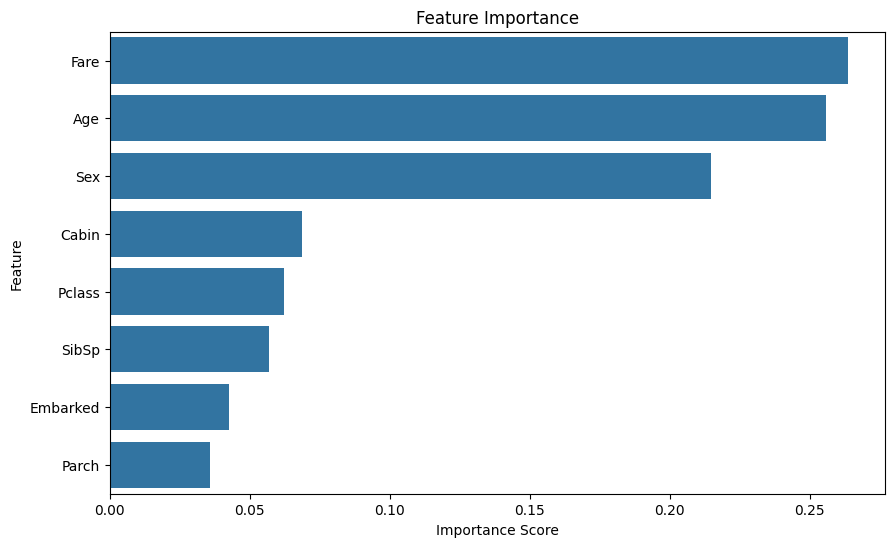

In [45]:
#feature importance

import seaborn as sns
import matplotlib.pyplot as plt

feature_names = df2.drop(columns=['Survived']).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [47]:
#hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

best_y_pred = best_model.predict(X_test)
best_conf_matrix = confusion_matrix(y_test, best_y_pred)

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_accuracy:.2f}")
print(f"Test Accuracy with Best Parameters: {accuracy_score(y_test, best_y_pred):.2f}")
print("Confusion Matrix with Best Parameters:")
print(best_conf_matrix)


Best Parameters: {'criterion': 'entropy', 'n_estimators': 50}
Best Cross-Validated Accuracy: 0.80
Test Accuracy with Best Parameters: 0.84
Confusion Matrix with Best Parameters:
[[92 13]
 [15 59]]


- n_estimators: model can be improved by reducing variance

- criterion: change from entropy to gini could indicate that the Gini impurity metric aligns better with the data distribution in this case.

- hyperparameter tuning not only improved the test accuracy but also reduced the confusion matrix errors.his reflects a better balance between precision and recall in predictions.

